# Python pour l’analyse des cartes TEC IONEX 

Ce script Python a pour objectif de lire, traiter, décompresser, visualiser et analyser les cartes TEC (Total Electron Content) issues de fichiers IONEX. Ces cartes représentent la densité totale d’électrons dans l’ionosphère, une donnée importante pour la correction des signaux GNSS.

Ce travail s’inspire du notebook [github](https://github.com/daniestevez/jupyter_notebooks/blob/master/IONEX.ipynb).

#### Periode étudiée :
La période étudiée s’étend du **1 au 17 août 2024**. 
Cette plage temporelle se situe au **maximum solaire du cycle 25**, période où le rayonnement extrême ultraviolet (EUV) émis par le Soleil est élevé, favorisant une forte ionisation de l’ionosphère. Le mois d'août est également proche de l’**anomalie équinoxiale** (effet saisonnier où la géométrie Terre–Soleil maximise la production électronique), ce qui contribue à élever les valeurs de TEC observées.
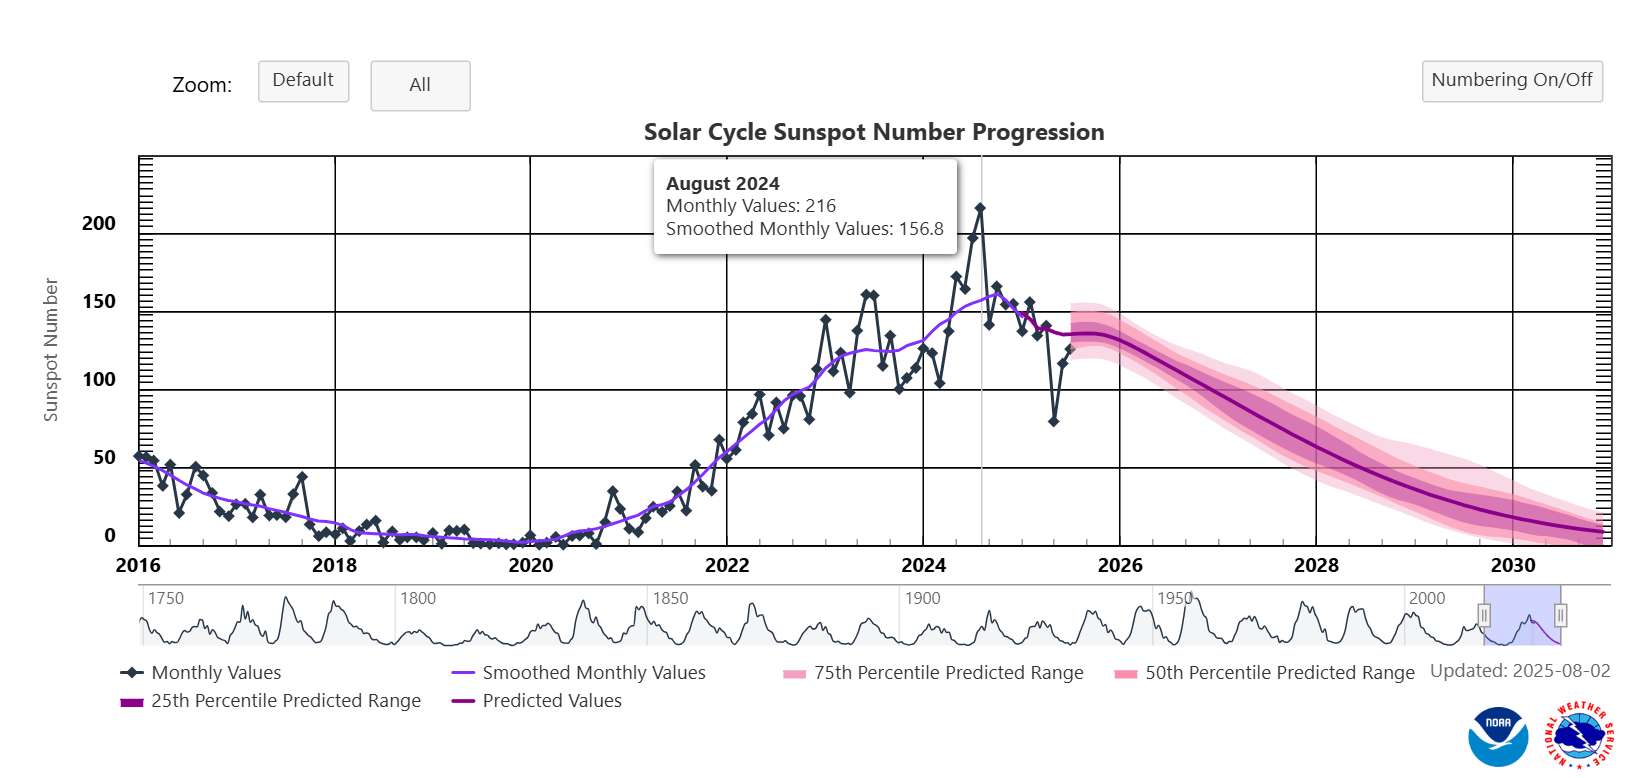 
Source du graphique : https://www.swpc.noaa.gov/products/solar-cycle-progression

Vous pouvez aussi choisir la plage temporelle de votre choix, avec le nombre de jour que vous souhaitez. Si vous souhaitez utiliser d'autres données, elles sont téléchargeables ici : https://cddis.nasa.gov/archive/gnss/products/ionex. La suite de ce notebook permet de directement télécharger les données de base.

In [ ]:
#télécharge les données IONEX 

!git clone https://github.com/ClementineBeau/Atelier-Ionex.git/data/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
!pip install cartopy
import cartopy
import cartopy.crs as ccrs                                                                               
import os
!pip install unlzw3 
import unlzw3

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/4f/ce/ba4baced164ecd78b4109cd611d7b64d256f012784e944c1b0f6f5dff5c1/Cartopy-0.24.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.8 from https://files.pythonhosted.org/packages/93/5b/842022c00fbb051083c1c85430f3bb55565b7fd2d775f4f398c0ba8052ce/shapely-2.1.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pyshp>=2.3 from https://files.pythonhosted.org/packages/98/2f/68116db5b36b895c0450e3072b8cb6c2fac0359279b182ea97014d3c8ac0/pyshp-2.3.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ---------------------------------------- 56.0/56.0 kB 2.9 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.1 from https://files.pythonhosted.org/packages/92/39/ef6f06a5b223dbea308cfcbb7a0f72e7b506aef1

ModuleNotFoundError: No module named 'cartopy'

## Paramètres

In [ ]:
fig_size = [14, 10]
plt.rcParams['figure.figsize'] = fig_size
folder_ionex ="/content/Fichiers-Atelier-IONEX/data-ionex"   

In [ ]:
https://www.spaceweatherlive.com/fr/archives.html mettre image

## Fonctions

In [ ]:
def parse_map(tecmap, exponent=-1):
    '''
    Extrait une carte TEC depuis une chaîne de texte brute issue d’un fichier IONEX
    '''
    tecmap = re.split('.*END OF TEC MAP', tecmap)[0]
    return np.stack(
        [np.fromstring(l, sep=' ') for l in re.split('.*LAT/LON1/LON2/DLON/H\\n', tecmap)[1:]]) * 10 ** exponent

def get_tecmaps(filename):
    '''
    Lit un fichier IONEX et retourne toutes les cartes TEC qu’il contient
    '''
    with open(filename) as f:
        ionex = f.read()
        return [parse_map(t) for t in ionex.split('START OF TEC MAP')[1:]]

def get_tec(tecmap, lat, lon):
    #Extrait la valeur TEC à une latitude et longitude données.
    i = round((87.5 - lat) * (tecmap.shape[0] - 1) / (2 * 87.5))
    j = round((180 + lon) * (tecmap.shape[1] - 1) / 360)
    return tecmap[i, j]

def plot_tec_map(tecmap):
    proj = ccrs.PlateCarree()
    f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj))
    ax.coastlines()
    h = plt.imshow(tecmap, cmap='viridis', vmin=0, vmax=100, extent=(-180, 180, -87.5, 87.5), transform=proj)
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    f.add_axes(ax_cb)
    cb = plt.colorbar(h, cax=ax_cb)
    cb.set_label('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')

def get_tecmaps_with_time(filename):
    with open(filename) as f:
        ionex = f.read()
    # Séparer en blocs correspondant aux cartes
    blocs = ionex.split('START OF TEC MAP')[1:]
    cartes_dates = []
    for bloc in blocs:
        # Extraire la date juste avant "START OF TEC MAP" dans le texte complet
        date_match = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})', bloc)
        if date_match:
            year, month, day, hour, minute, second = map(int, date_match.groups())
        else:
            year, month, day, hour, minute, second = (0, 0, 0, 0, 0, 0)

        tecmap = parse_map(bloc)
        cartes_dates.append(((year, month, day, hour, minute, second), tecmap))
    return cartes_dates

def decompress_ionex_file(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Fichier non trouvé : {filepath}")
    if filepath.lower().endswith(".z"):
        filepath_out = filepath[:-2]
    else:
        print(f"Fichier déjà décompressé: {filepath}")
        return filepath
    if os.path.exists(filepath_out):
        print(f"Fichier déjà décompressé : {filepath_out}")
        return filepath_out
    if filepath.lower().endswith(".z"):
        with open(filepath, 'rb') as f_in:
            data = unlzw(f_in.read())
        with open(filepath_out, 'wb') as f_out:
            f_out.write(data)
        print(f"Décompression .Z réussie, {filepath_out}")
    return filepath_out


def plot_tec_map_ax(tecmap, ax):
    ax.clear()
    ax.coastlines()
    proj = ccrs.PlateCarree()
    im = ax.imshow(tecmap, cmap='viridis', vmin=0, vmax=100,
                   extent=(-180, 180, -87.5, 87.5),
                   transform=proj)
    return im

## Tracer le TEC mondial - carte intéractive

In [2]:
files_ionex_Z = sorted(os.listdir(folder_ionex))

if files_ionex_Z:
    first_file_path = os.path.join(folder_ionex, files_ionex_Z[0])
    file_ionex_i = decompress_ionex_file(first_file_path)
carte_dates = get_tecmaps_with_time(file_ionex_i)


proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(14, 10))
plt.subplots_adjust(bottom=0.25)
date0, tecmap0 = carte_dates[0]
im = plot_tec_map_ax(tecmap0, ax)
title = ax.set_title(f"VTEC map — {date0[0]}-{date0[1]:02d}-{date0[2]:02d} {date0[3]:02d}:{date0[4]:02d}:{date0[5]:02d}")
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])  # position [gauche, bas, largeur, hauteur]
slider = Slider(ax_slider, 'Temps', 0, len(carte_dates) - 1, valinit=0, valstep=1)
def update(val):
    idx = int(slider.val)
    date, tecmap = carte_dates[idx]
    im.set_data(tecmap)
    title.set_text(f"VTEC map — {date[0]}-{date[1]:02d}-{date[2]:02d} {date[3]:02d}:{date[4]:02d}:{date[5]:02d}")
    fig.canvas.draw_idle()
slider.on_changed(update)
plt.show()

NameError: name 'os' is not defined

## Tracer les variations journalières du TEC à Québec 

NameError: name 'files_ionex_Z' is not defined

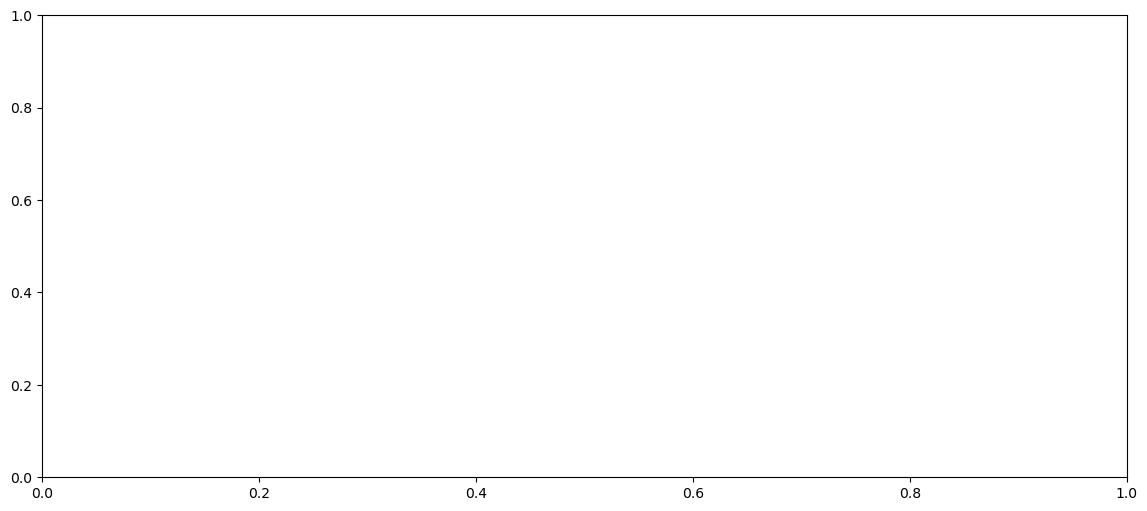

In [3]:
lat_QC = 46.8139 #coordonnées hotel de ville de Québec
lon_QC = -71.2082
fig, ax = plt.subplots(figsize=(14, 6))

norm = matplotlib.colors.Normalize(vmin=1, vmax=8)
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
lat_QC = 46.8139
lon_QC = -71.2082
for day_idx, file in enumerate(sorted(files_ionex_Z), start=1):
    file_path = os.path.join(folder_ionex, file)
    file_ionex_i = decompress_ionex_file(file_path)
    carte_dates = get_tecmaps_with_time(file_ionex_i)
    # Construction des paires (heure, tec) et tri
    data_points = [
        (date[3] + date[4] / 60.0, get_tec(tecmap, lat_QC, lon_QC))
        for date, tecmap in carte_dates
    ]
    data_points.sort()  # tri croissant sur l'heure
    heures, tec_values = zip(*data_points)  # unzip les listes triées
    ax.plot(heures, tec_values, color=cmap(norm(day_idx)), alpha=0.4)
ax.set_title('Variations journalières du VTEC à Québec (1 courbe par jour, 8 jours)')
ax.set_xlabel('Heure UTC')
ax.set_ylabel('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')
ax.grid(True)
ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0, 25, 2))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Jour')
plt.tight_layout()
plt.show()
